In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [23]:
yelp_df = pd.read_csv("sentiment_data/yelp_labelled.txt", delimiter="\t", header=None)
yelp_df.columns = ["review", "sentiment"]
amazon_df = pd.read_csv("sentiment_data/amazon_cells_labelled.txt", delimiter="\t", header=None)
amazon_df.columns = ["review", "sentiment"]

yelp_df.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Since the dataset is 1000 rows long, I'll take 700 as my training set, and 300 as my cross-validation.  (The set is small enough that I'm not going to worry about a separate test set.)

In [28]:
ytrain_df = yelp_df.iloc[:700].copy()
ycv_df = yelp_df.iloc[700:].copy()

atrain_df = amazon_df.iloc[:700].copy()
acv_df = amazon_df.iloc[700:].copy()

# Feature selection

Here's where things get interesting.  I thought that manually picking words seemed a little hacky and boring.  Instead, in a move that turned out to be ill-fated for my schedule, I decided to write a function that mathematically defines optimality for word selection based in its distribution in the dataset, and let that function pick the top however-many-I-want words for me.

The function is called add_best_words.  The bulk of the function is pretty uninteresting legwork (albeit good practice), but the scoring function at the start is worth a look.  I thought I defined the function to be mathematically optimal: it's pretty much a simple application of Bayes' Theorem.  As we'll see in the testing below, it turned out to be a bit weirder than that.

In [29]:
from add_best_words import add_best_words
ytrain_df, keywords = add_best_words(ytrain_df, "review", "sentiment", 30)
print(keywords)

['great', 'friendly', 'delicious', 'really', 'amazing', 'Great', 'also', 'nice', 'fantastic', 'excellent', 'prices', 'tender', 'wonderful', 'town', 'Good', 'spot', 'clean', 'happy', 'and', 'not', '!', "n't", 'is', 'minutes', 'there', 'good', 'never', 'with', 'very', 'are', 'being', 'bad']


Based on the heatmap below, I added a few ad-hoc exceptions to my add_best_words function to eliminate periods and "do", which correlated alarmingly closely with exclamation marks and "n't", both of which are more expressive than their counterparts.  The rest here look reasonably uncorrelated, though far from perfect.

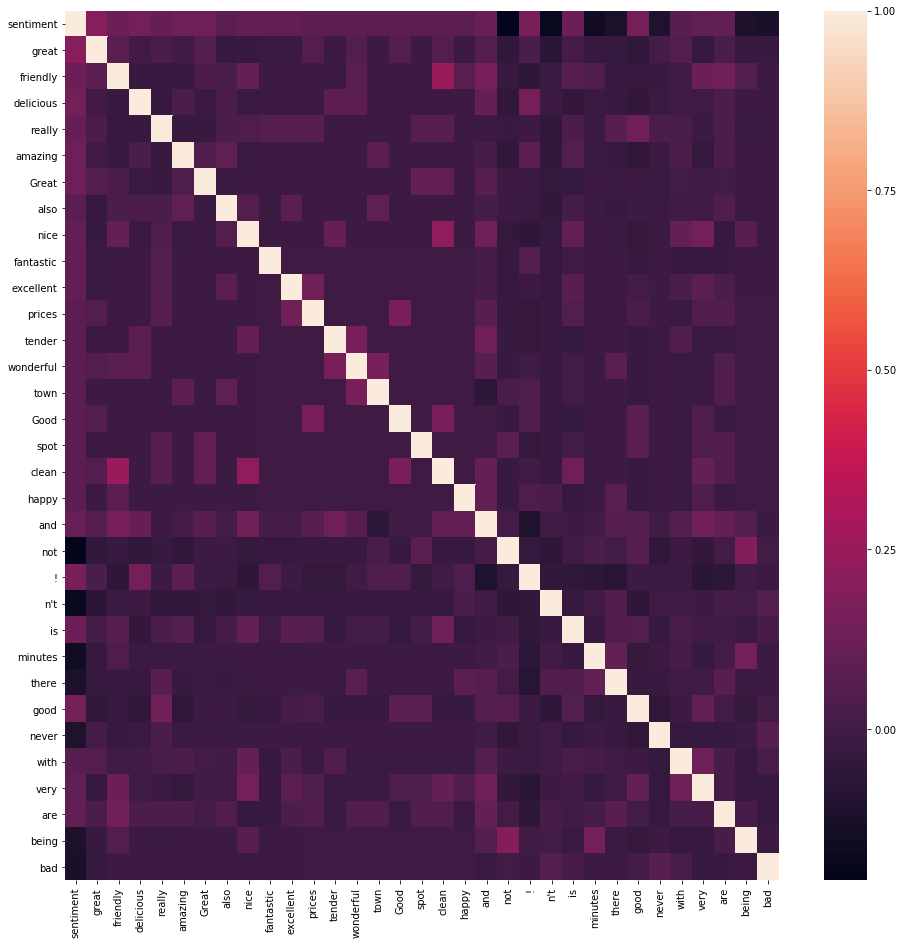

In [5]:
plt.figure(figsize=(16,16))
sns.heatmap(ytrain_df.corr());

# Testing our features
There's not a whole lot to tweak here - that I know of - in the model itself.  The distributions of these binary variables are clearly Bernoulli.  However, there's definite testing and tweaking needed for this method of feature selection.  First, a one-off test of the 30 words we compiled above:

In [30]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from nltk import word_tokenize

ycv_df["review"] = ycv_df["review"].apply(word_tokenize)
for word in keywords:
    ycv_df[word] = [word in li for li in ycv_df["review"]]

data = ytrain_df[keywords]
target = ytrain_df["sentiment"]

bnb = BernoulliNB()
bnb.fit(data, target)
y_pred = bnb.predict(ycv_df[keywords])
score = metrics.f1_score(ycv_df["sentiment"], y_pred)
print("Your model achieved an f1-score of " + str(score))
from sklearn.metrics import confusion_matrix
print("confusion matrix:")
print(confusion_matrix(ycv_df["sentiment"], y_pred))
from sklearn.model_selection import cross_val_score
print("cross-validation scores:")
print(cross_val_score(bnb, data, target, cv=10))

Your model achieved an f1-score of 0.625
confusion matrix:
[[124  68]
 [ 28  80]]
cross-validation scores:
[0.71830986 0.66197183 0.77142857 0.75714286 0.75714286 0.67142857
 0.72857143 0.74285714 0.72463768 0.84057971]


But of course it would be much better to test this across multiple different numbers.  Let's write a function to iterate this and produce values we can plot.

In [7]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from add_best_words import add_best_words
from nltk import word_tokenize
def model_score(num_words, score_func=None):
    ytrain_df = yelp_df.iloc[:700].copy()
    ycv_df = yelp_df.iloc[700:].copy()
    ytrain_df, keywords = add_best_words(ytrain_df, "review", "sentiment", num_words)
    
    # set up ycv_df with added keywords
    ycv_df["review"] = ycv_df["review"].apply(word_tokenize) 
    for word in keywords:
        ycv_df[word] = [word in li for li in ycv_df["review"]]

    data = ytrain_df[keywords]
    target = ytrain_df["sentiment"]
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(ycv_df[keywords])
    score = metrics.f1_score(ycv_df["sentiment"], y_pred)
    return score

# print(model_score(30))

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

In this plot, we can see a definite peak around an f-score of .650 - not bad.  It's instructive to note the clear peak at 40 and subsequent regression - a sign of overfitting the dataset.  This means that we could likely do much better with this method given more data.

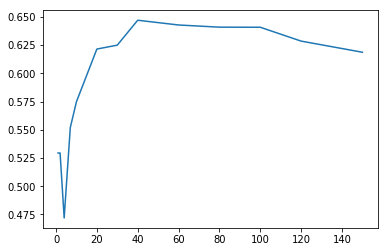

In [8]:
x = [1,2,4,7,10,20,30,40, 60, 80, 100, 120, 150]
y = [model_score(x1) for x1 in x]
plt.plot(x,y)

What's a bit surprising here is that my initial model, which used a first intuitive guess for its word score criteria rather than a strict encoding of Bayes' Theorem, actually scored slightly higher, and din't show the overfitting that the curve above shows.  Below is the curve produced by that early model.  The formula operating here scored each word according to the formula: <br><br>
<i> score = 1 - (smaller_affect_frequency / larger_affect_frequency)</i><br><br>
where smaller_affect_frequency is the relative frequency of the word across the concatenated negative or positive text, whichever is smaller (and vice-versa for larger_affect_frequency).
<img src="files/intuitive.png" height="450" width="450">

The current formula multiplies the Bayesian probabilistic value of the word (defined as the distance to which it nudges the probability of the sentence's affect away from a neutral 0.5) by the square root of the frequency of that word in the dataset.  Logically, it ought to be multiplied by the frequency, but that didn't work quite as well.
<br><br>
We can also try this method on the Amazon dataset and see how it transfers.

In [9]:
def model_score_amazon(num_words, score_func=None):
    atrain_df = amazon_df.iloc[:700].copy()
    acv_df = amazon_df.iloc[700:].copy()
    atrain_df, keywords = add_best_words(atrain_df, "review", "sentiment", num_words)
    
    # set up ycv_df with added keywords
    acv_df["review"] = acv_df["review"].apply(word_tokenize) 
    for word in keywords:
        acv_df[word] = [word in li for li in acv_df["review"]]

    data = atrain_df[keywords]
    target = atrain_df["sentiment"]
    bnb = BernoulliNB()
    bnb.fit(data, target)
    a_pred = bnb.predict(acv_df[keywords])
    score = metrics.f1_score(acv_df["sentiment"], a_pred)
    return score

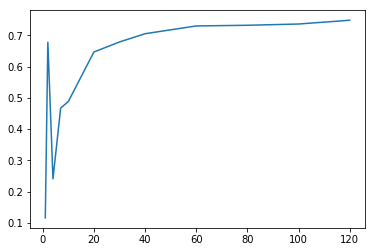

In [10]:
x = [1,2,4,7,10,20,30,40, 60, 80, 100, 120]
y = [model_score_amazon(x1) for x1 in x]
plt.plot(x,y)

Interestingly, this method performs significantly better over the Amazon dataset.  This is probably because the Amazon set effictively gives more data, which helps with the overfitting problem as well as general learning.  The Amazon dataset has the same number of rows, but the average length of review is longer.

# Conclusions
This has been a very interesting exploration.  I don't quite feel satisfied, though: I'm not sure why my Bayesian formula for selecting features isn't precisely optimal, nor do I understand why my intuitive attempt fared slightly better.  I'd like to discuss this more and see if we can figure it out.

There are a few other tweaks I could try that might make little gains.  I could try using my custom wordify function that I wrote for my stylometer app, which runs a little faster than nltk's stemmer and omits punctuation, which could help or harm the outcomes.  I could also try using a stemmer (I've found the Snowball Stemmer to be best for most purposes) so that I'm comparing vocabulary use rather than specific word forms - that could actually make some significant gains.  But again, for now, I'm most interested in optimizing my scoring function.

In [ ]:
# Try using a basic non-bournelli NB?